# M1: Primate Reach and Grasp 

M1 is a dataset originally collected to dissociate the effect of location and object in reach and grasp behaviors. This data has been previously discussed in [Rouse and Schieber 2015, J Neurophys]((https://journals.physiology.org/doi/full/10.1152/jn.00686.2015)), [Rouse and Schieber 2016, J Neurosci]((https://www.jneurosci.org/content/36/41/10640?utm_source=TrendMD&utm_medium=cpc&utm_campaign=JNeurosci_TrendMD_0)), [Rouse and Schieber 2016, J Neurophys]((https://journals.physiology.org/doi/full/10.1152/jn.00008.2016)),  and [Rouse and Schieber 2018, Cell Reports]((https://www.cell.com/cell-reports/fulltext/S2211-1247(18)31833-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2211124718318333%3Fshowall%3Dtrue)).

The dataset contains neural activity of a rhesus monkey implanted with 6 floating microelectrode arrays (16 channels each, electrodes of length 1.5-8mm). In addition, intramuscular electromyography (EMG) is recorded from 16 locations of the right hand and upper extremity muscles, including: anterior deltoid (DLTa), posterior deltoid (DLTp), pectoralis major (PECmaj), short head of biceps (BCPs), lateral head of triceps (TCPlat), flexor carpi radialis (FCR), flexor carpi ulnaris (FCU), extensor carpi radialis brevis (ECRB), extensor carpi ulnaris (ECU), radial and ulnar flexor digitorum profundus (FDPr, FDPu), abductor pollicis longus (APL), extensor digitorum communis (EDC), thenar muscle group (Thenar), first dorsal interosseus (FDI), and hypothenar muscle group (Hypoth). 

# Task 

The monkey has been trained to reach to, grasp, and manipulate 4 different objects at 8 different locations, arranged in a center-out fashion. The objects are separated by 45 degrees with a fifth object in the middle. The center object is a coaxial cylinder, and the four peripheral (target) objects include: a button mounted inside a tube, a sphere, a perpendicular cylinder, and a coaxial cylinder identical to the center object. The trained manipulation schemes are as follows: cylinders are pulled towards the subject, the button is pushed, and the sphere is rotated 45 degrees. The objects are in a fixed order (perpendicular cylinder, coaxial cylinder, button, sphere) spanning 135 degrees of a circle, and objects were rotated to one of eight orientations in 22.5 degree increments [some positions excluded due to biomechanical or visual constraints]. 

At the start of each trial, the monkey pulls on the center cylinder and holds for 1500-2000ms. Then, a blue light cues a pheripheral object. For a trial to be successful, the monkey needs to reach to, grasp, and manipulate the cued object within 1000ms and hold the object in the manipulated state for 1000ms. 

# Use in FALCON

This dataset provides four training datasets and four evaluation datasets. This task is important to the discussion of BCI stability as it focuses on EMG decoding, which tests a model's ability to predict many output variables. In addition, EMG decoding is relevant to BCI efforts to use functional electrical stimulation (FES) to stimulate a user's own limb to create movement.

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import numpy as np
from pynwb import NWBHDF5IO
from data_demos.styleguide import set_style
set_style()

/tmp/ipykernel_2532770/3245306384.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [13]:
train_path = Path('/snel/share/share/derived/rouse/RTG/NWB_FALCON/full')
test_path = Path('/snel/share/share/derived/rouse/RTG/NWB_FALCON/calibration')

train_files = sorted(train_path.glob('*.nwb'))
test_files = sorted(test_path.glob('*.nwb'))

def get_start_date_and_volume(fn: Path):
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()
        start_date = nwbfile.session_start_time.strftime('%Y-%m-%d') # full datetime to just date
        raw_emg = nwbfile.processing['emg_filtering_module'].get_data_interface('emg')
        muscles = [ts for ts in raw_emg.time_series]
        mdata = raw_emg.get_timeseries(muscles[0])
        timestamps = mdata.timestamps[:]

        return pd.to_datetime(start_date), timestamps.shape[0]

start_dates, volume = zip(*[get_start_date_and_volume(fn) for fn in train_files + test_files])
split_type = ['Train'] * len(train_files) + ['Test'] * len(test_files) 


/home/bkarpo2/miniconda3/envs/stbm/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'APL': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
/home/bkarpo2/miniconda3/envs/stbm/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'BCPs': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
/home/bkarpo2/miniconda3/envs/stbm/lib/python3.11/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'DLTa': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
/home

/tmp/ipykernel_2532770/4045619772.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(


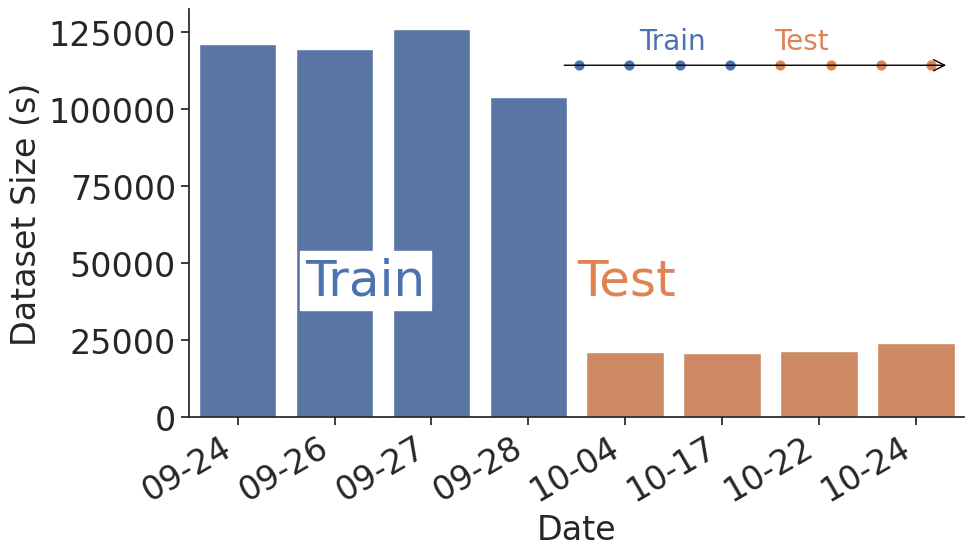

In [15]:
# Convert to pandas dataframe for easier manipulation
df = pd.DataFrame({'Date_Full': start_dates, 'Dataset Size': volume, 'Split Type': split_type})
# just get month and day
BIN_SIZE_S = 0.02
df['Dataset Size (s)'] = df['Dataset Size'] * BIN_SIZE_S
df['Date'] = df['Date_Full'].dt.strftime('%m-%d')

fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for visualizing each start date on the same y-value
palette = sns.color_palette(n_colors=3)
sns.barplot(
    x='Date', 
    y='Dataset Size (s)', 
    data=df, 
    ax=ax, 
    order=df['Date'].sort_values(), 
    estimator=np.sum, 
    errorbar=None, 
    hue='Split Type',
    palette=palette
)
ax.get_legend().remove()
ax.text(0.15, 0.3, 'Train', color=palette[0], fontsize=36, transform=ax.transAxes, backgroundcolor='white')
ax.text(0.5, 0.3, 'Test', color=palette[1], fontsize=36, transform=ax.transAxes)
fig.autofmt_xdate()  # Rotate dates for readability

def plot_timeline(ax, sections, colors):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    # Creating an inset for the timeline
    ax_inset = inset_axes(ax, width="50%", height="20%", loc='upper right', borderpad=1)

    # Plotting the colorized timeline in the inset
    for i, (section, dates) in enumerate(sections.items()):
        ax_inset.scatter(dates, [0] * len(dates), marker='o', color=colors[i], s=40)

    # Configuring the inset
    ax_inset.set_yticks([])
    ax_inset.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax_inset.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax_inset.xaxis.set_major_locator(plt.MaxNLocator(3))
    sns.despine(ax=ax_inset, left=True, bottom=True, right=True, top=True)
    ax_inset.axis('off')
    ax_inset.annotate('', xy=(1, 0), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color='black'),
                xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'))
    ax_inset.text(
        0.2, 0.7, 'Train', 
        color=colors[0],
        fontsize=20, 
        transform=ax_inset.transAxes
    )
    ax_inset.text(
        0.55, 0.7, 'Test', 
        color=colors[1],
        fontsize=20,
        transform=ax_inset.transAxes
    )
sections = df.groupby(
    'Split Type'
)['Date'].apply(list).to_dict()
# sort section by section name, respect Train, Test Short, Test Long order
sections = {k: v for k, v in sorted(sections.items(), key=lambda item: item[1])}
plot_timeline(ax, sections, palette)

sample_files = [
    *train_files,
    *test_files
]


# Quick Overview

The primary components of the dataset include recorded neural activity, EMG (which has been rectified and filtered), and trial metadata, such as start, go-cue, and stop times. 

Here we will visualize the experimental data. We will first load the NWB files, bin the spike times, and then plot the binned spikes and EMG.

In [ ]:
from falcon_challenge.dataloaders import bin_units

def load_nwb(fn: str):
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()

        trial_info = (
            nwbfile.trials.to_dataframe()
            .reset_index()
            .rename({"id": "trial_id", "stop_time": "end_time"}, axis=1)
        )

        units = nwbfile.units.to_dataframe()
        raw_emg = nwbfile.processing['emg_filtering_module'].get_data_interface('preprocessed_emg')
        muscles = [ts for ts in raw_emg.time_series]
        emg_data = []
        emg_timestamps = []
        for m in muscles: 
            mdata = raw_emg.get_timeseries(m)
            data = mdata.data[:]
            timestamps = mdata.timestamps[:]
            emg_data.append(data)
            emg_timestamps.append(timestamps)

        emg_data = np.vstack(emg_data).T 
        emg_timestamps = emg_timestamps[0]

        trial_info.start_time = trial_info.start_time.round(2)
        trial_info.end_time = trial_info.end_time.round(2)

        return (
            bin_units(units, bin_size_s=0.02),
            emg_data,
            emg_timestamps,
            muscles,
            trial_info,
        )

In [ ]:
# %% plot some continuous raster/EMG data 

fig, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True, sharey=False)
def rasterplot(spike_arr, bin_size_s=0.01, ax=None):
    if ax is None:
        ax = plt.gca()
    for idx, unit in enumerate(spike_arr.T):
        ax.scatter(np.where(unit)[0] * bin_size_s, np.ones(np.sum(unit != 0)) * idx, s=1, c='k', marker='|')
    ax.set_xticks(np.arange(0, spike_arr.shape[0]*bin_size_s, 5))
    ax.set_xticklabels(np.arange(0, spike_arr.shape[0], 500) * bin_size_s)
    ax.set_yticks(np.arange(0, spike_arr.shape[1], 20))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neuron #')
    # remove splines 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

rasterplot(units[:4001, :], ax=ax[0])

ax[1].plot(time[:4001], emg[:4001, :], linewidth=0.75, color='k', alpha=0.7)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('EMG')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Neural activity statistics change over time 

# Plot multiple days back to back to note change in structure

f, axes = plt.subplots(2, 1, figsize=(10, 7), layout='constrained')

rasterplot(binned_neural, ax=axes[0])
day_intervals = np.cumsum(lengths)
for i, length in enumerate(day_intervals[:-1]):
    if start_dates[i] == start_dates[i + 1]:
        continue 
    axes[0].axvline(length * BIN_SIZE_S, color='r', linewidth=1)

# Plot mean firing rates in different days
daily_means = []
day_intervals = [0, *np.cumsum(lengths)]
for start, end in zip(day_intervals[:-1], day_intervals[1:]):
    daily_means.append(np.mean(binned_neural[start:end], axis=0))
# daily_means is a list of 8 arrays, each of shape (N,) - histplot them separately using sns and pd
flattened_data = {'Day': [], 'Mean Firing Rate (Hz)': []}
for day, means in zip(start_dates, daily_means):
    flattened_data['Day'].extend([day.strftime('%m-%d')] * len(means))  # Extend day labels - reformat for simplicity
    flattened_data['Mean Firing Rate (Hz)'].extend(means)  # Extend mean firing rates
    
axes[1] = sns.histplot(data=flattened_data, x='Mean Firing Rate (Hz)', hue='Day', kde=True, ax=axes[1], palette='viridis', bins=20, stat='percent', multiple='dodge')
axes[1].set_title('Firing Rate Distribution per day', ha='center', va='center', transform=axes[1].transAxes, fontsize=18)


# Training and evaluating a linear decoder 

In [ ]:

# Assuming smoothed_spikes and emg are 2D arrays with the same number of rows as time
smoothed_spikes_trials = []
emg_trials = []

for _, trial in trials.iterrows():
    start_time = trial['start_time']
    end_time = trial['end_time']

    # Find the indices in the time array that correspond to the start and end times
    start_idx = np.searchsorted(time, start_time)
    end_idx = np.searchsorted(time, end_time)

    # Extract the regions of smoothed_spikes and emg that fall between start_time and end_time
    smoothed_spikes_region = smoothed_spikes[start_idx:end_idx, :]
    emg_region = emg[start_idx:end_idx, :]

    # Append the regions to the lists
    smoothed_spikes_trials.append(smoothed_spikes_region)
    emg_trials.append(emg_region)

# %% split into train and valid 
from sklearn.model_selection import train_test_split

# Split the smoothed_spikes_regions into training and validation sets
smoothed_spikes_train, smoothed_spikes_valid = train_test_split(smoothed_spikes_trials, test_size=0.2, random_state=42)

# Split the emg_regions into training and validation sets
emg_train, emg_valid = train_test_split(emg_trials, test_size=0.2, random_state=42)

#%% train a decoder 

from sklearn.linear_model import Ridge 

# Create a decoder
decoder = Ridge(alpha=1.0)
X = np.vstack(smoothed_spikes_train)
y = np.vstack(emg_train)

decoder.fit(X, y)
decoder.score(X, y)

# %%

from sklearn.metrics import r2_score

# Initialize a list to store the scores
scores = []
preds = []

# Loop through each example in smoothed_spikes_valid
for i in range(len(smoothed_spikes_valid)):
    # Use the decoder to predict an output
    y_pred = decoder.predict(smoothed_spikes_valid[i])

    # Score the prediction using the corresponding example from emg_valid
    score = r2_score(emg_valid[i], y_pred, multioutput='variance_weighted')

    # Append the score to the list
    scores.append(score)
    preds.append(y_pred)

# Print the average score
print('Average score:', np.mean(scores))

# %%
# Get the number of dimensions in the second axis of emg_valid
trial_id = 0
num_dims = emg_valid[trial_id].shape[1]

# Create a grid of subplots with num_dims rows and 1 column
fig, ax = plt.subplots(num_dims//2, 2, figsize=(7, 7), sharex=True, sharey=True)
axs = ax.flatten()

# Loop through each dimension
for i in range(num_dims):
    # Get the true and predicted data for the trial and dimension
    true_data = emg_valid[trial_num][:, i]
    predicted_data = preds[trial_num][:, i]

    # Plot the data in the subplot
    axs[i].plot(true_data, label='True', color='k', linewidth=0.75, alpha=0.7)
    axs[i].plot(predicted_data, label='Predicted', color='r', linewidth=0.75, alpha=0.7)
    axs[i].set_ylabel(muscle_names[i])
    if i == 0:
        axs[i].legend()

plt.suptitle(f'R2: {np.around(scores[trial_id], 3)}')
plt.tight_layout()
plt.show()

# %%


# Multi-day decoding 